              GAZ         BCP         CDM          CGI          HOL  \
mean  1510.454545  164.243182  772.725000  1545.630303  2106.393939   
std    150.812281   35.765188  119.631287   570.668064   391.258792   
min   1110.000000  103.500000  471.000000   558.000000  1461.000000   

             LYD         SAM          SID          WAA  
mean  321.164394  601.552273  2112.419697  2695.378788  
std    64.239086  141.722839   875.474152   567.414291  
min   205.950000  270.100000   584.900000  1755.000000  


<AxesSubplot:>

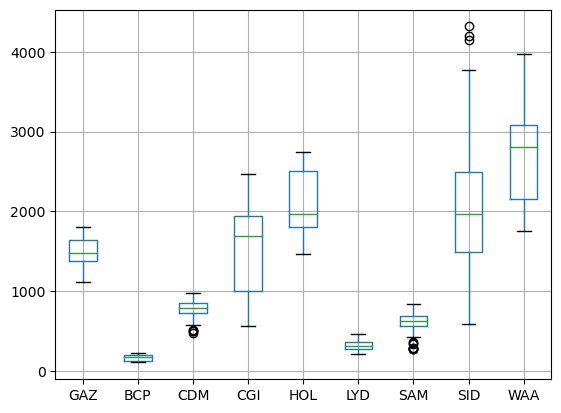

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import seaborn as sns

#file_path = input("Entrer file path de Test_PE_2023.xlsx : ")

# Read data from Excel file

df = pd.read_excel("Test_PE_2023.xlsx")


# Description de donnees


a=df.describe()
a.iloc[[1,2,3,],]

print(a.iloc[[1,2,3,],])
# Suppression des colonnes inutiles
df = df.drop(['DATE'], axis=1)

df.boxplot()


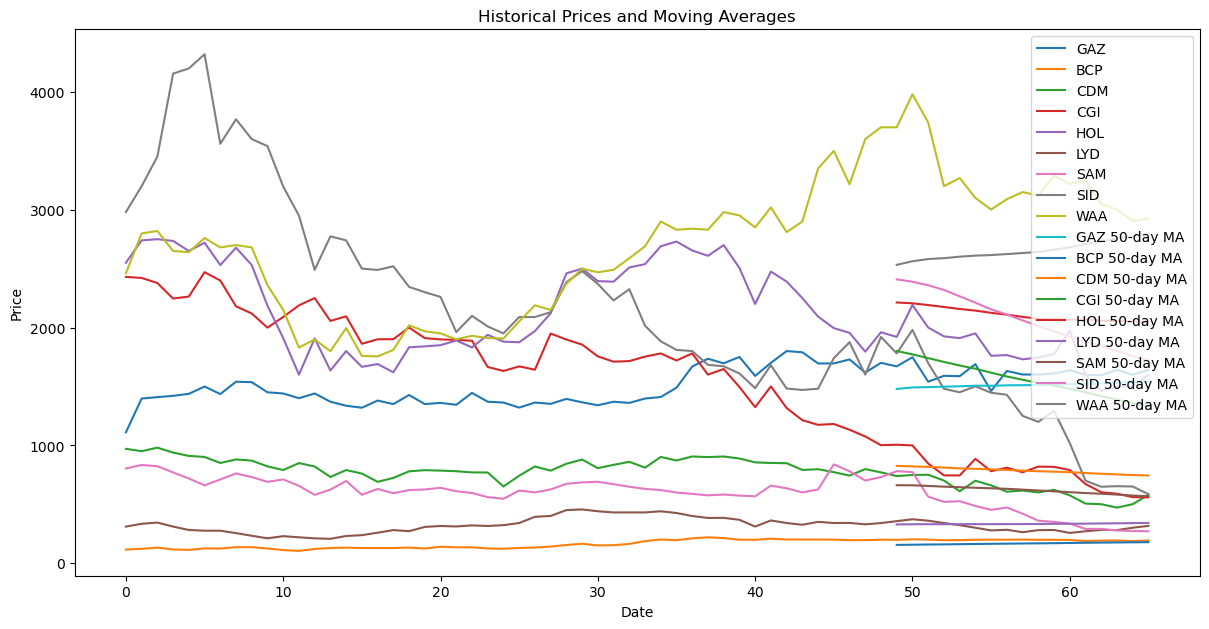

In [60]:
# Calculate moving averages
window = 50  # Define the window size for the moving average
moving_averages = df.rolling(window).mean()

# Plotting historical prices and moving averages
plt.figure(figsize=(12, 6))
for column in df.columns:
    plt.plot(df.index, df[column], label=column)

plt.tight_layout()
for column in moving_averages.columns:
    plt.plot(df.index, moving_averages[column], label=f'{column} {window}-day MA')
plt.title('Historical Prices and Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc=1)
plt.show()


In [65]:
# Calcul des rendements logarithmiques
returns = (df - df.shift(1)) / df.shift(1)
# Calcul des moyennes et de la matrice de covariance des rendements
mean_returns = returns.mean()
cov_matrix = returns.cov()

# Fonction objectif pour l'optimisation
def objective(weights):
    weights = np.array(weights)
    portfolio_return = np.sum(mean_returns * weights) * 252
    portfolio_variance = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return -portfolio_return / portfolio_variance

# Contraintes pour l'optimisation
def constraint(weights):
    return np.sum(weights) - 1

# Définition des bornes et des contraintes
bounds = [(0, 1)] * len(df.columns)
constraints = [{'type': 'eq', 'fun': constraint}]

# Optimisation du portefeuille
initial_weights = [1 / len(df.columns)] * len(df.columns)
result = minimize(objective, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)

# Affichage des résultats
print('Poids optimaux du portefeuille :')
for i, column in enumerate(df.columns):
    weight = result.x[i] if result.x[i] > 0.001 else 0
    print(f'{column}: {weight}')

# Calcul des rendements et risques pour différentes allocations
port_returns = []
port_risks = []
for _ in range(10000):
    weights = np.random.random(len(df.columns))
    weights /= np.sum(weights)
    returns = np.sum(mean_returns * weights) * 252
    risks = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    port_returns.append(returns)
    port_risks.append(risks)


portfolio_return = np.sum(mean_returns * result.x) * 12
portfolio_variance = np.sqrt(np.dot(result.x.T, np.dot(cov_matrix, result.x))) * np.sqrt(12)
portfolio_ratio = portfolio_return / portfolio_variance
print(f'Rendement du portefeuille  : {portfolio_return}')
print(f'Ratio à optimiser : {portfolio_ratio}')




Poids optimaux du portefeuille :
GAZ: 0.3856253013736533
BCP: 0.6006555207721064
CDM: 0
CGI: 0
HOL: 0
LYD: 0.013719177854299477
SAM: 0
SID: 0
WAA: 0
Rendement du portefeuille  : 0.10358357752500785
Ratio à optimiser : 0.65417065142694


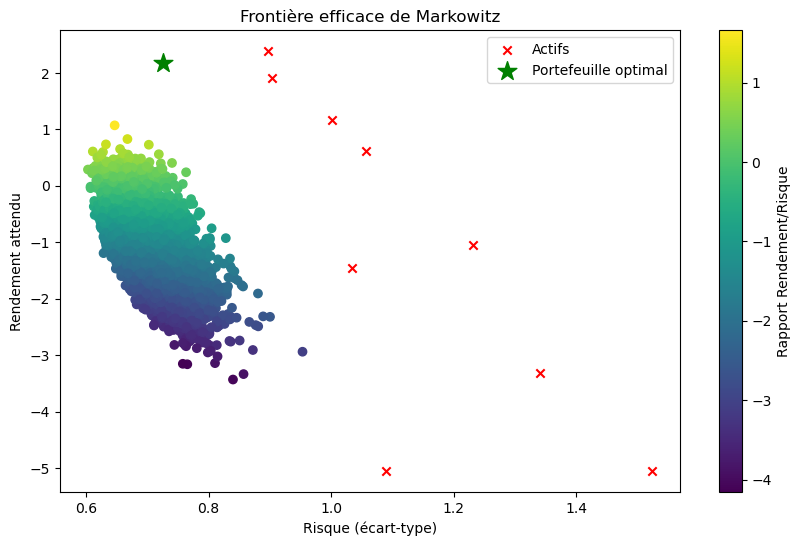

In [47]:
# Tracé du portefeuille et du ratio rendement/risque
plt.figure(figsize=(10, 6))
plt.scatter(np.array(port_risks), np.array(port_returns), c=np.array(port_returns)/np.array(port_risks), marker='o', cmap='viridis')
plt.colorbar(label='Rapport Rendement/Risque')
plt.scatter(np.sqrt(np.diagonal(cov_matrix))*np.sqrt(252), mean_returns*252, marker='x', color='red', label='Actifs')
plt.scatter(np.sqrt(np.dot(result.x.T, np.dot(cov_matrix, result.x)))*np.sqrt(252),
            np.sum(mean_returns * result.x) * 252, marker='*', color='green', s=200, label='Portefeuille optimal')
plt.title('Frontière efficace de Markowitz')
plt.xlabel('Risque (écart-type)')
plt.ylabel('Rendement attendu')
plt.legend()
plt.show()
